In [49]:
import osmnx as ox
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio.merge
from rasterio.mask import mask
import json
from pathlib import Path

from rasterio import Affine
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
from pathlib import Path
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling


# Graz shape for clipping

Saved Graz boundary to: ../data/MidtermPro/Data/OutputIPYNB/Graz31256.geojson
CRS: EPSG:31256


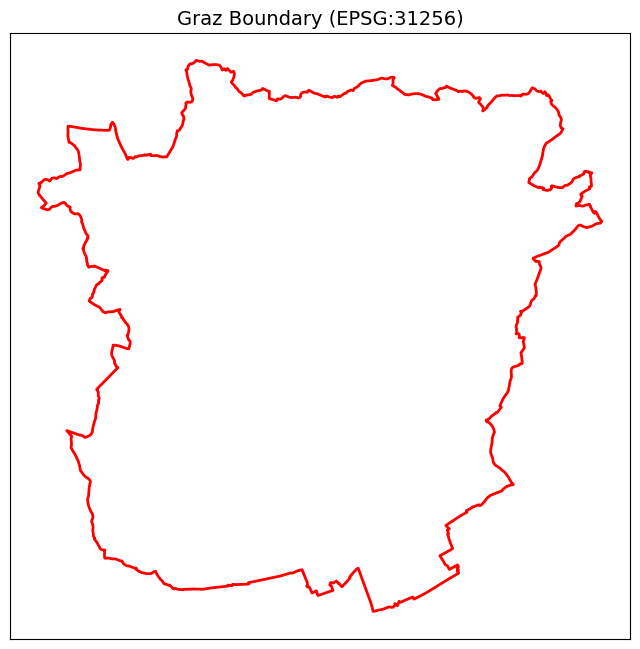

In [10]:


PLACE = "Graz, Austria"

graz = ox.geocode_to_gdf(PLACE)
graz_31256 = graz.to_crs(31256)

# Bounds
minx, miny, maxx, maxy = map(float, graz_31256.total_bounds)

# Correct output path (with / after .. )
out_path = Path("../data/MidtermPro/Data/OutputIPYNB/Graz31256.geojson")
graz_31256.to_file(out_path, driver="GeoJSON")

print("Saved Graz boundary to:", out_path)
print("CRS:", graz_31256.crs)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

graz_31256.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=2
)

ax.set_xticks([])
ax.set_yticks([])
#ax.set_title("Graz Boundary (EPSG:31256)", fontsize=14)

plt.show()

# DEM Clip to Graz Boundary

In [ ]:


# Paths
dem_path = Path("../data/MidtermPro/Data/dem_mosaic31256.tif")
graz_path = Path("../data/MidtermPro/Data/Graz31256.geojson")

# Load Graz polygon
graz = gpd.read_file(graz_path)


# Extract geometry in GeoJSON format
graz_geom = [json.loads(graz.to_json())["features"][0]["geometry"]]

# Clip raster
with rasterio.open(dem_path) as src:
    dem_clip, dem_transform = mask(
        src,
        graz_geom,
        crop=True,
        nodata=src.nodata
    )
    clip_meta = src.meta.copy()
    clip_meta.update({
        "height": dem_clip.shape[1],
        "width": dem_clip.shape[2],
        "transform": dem_transform,
        "nodata": src.nodata
    })

# Save clipped DEM
clip_path = Path("../data/MidtermPro/Data/dem_graz31256.tif")

with rasterio.open(clip_path, "w", **clip_meta) as dst:
    dst.write(dem_clip)

print("DEM Graz saved:", clip_path)

# Quick min/max check
import numpy as np
masked = np.ma.masked_equal(dem_clip, clip_meta["nodata"])
print("DEM Graz min:", masked.min(), "max:", masked.max())

DEM Graz saved: ../data/MidtermPro/Data/dem_graz31256.tif
DEM Graz min: 326.22 max: 758.16


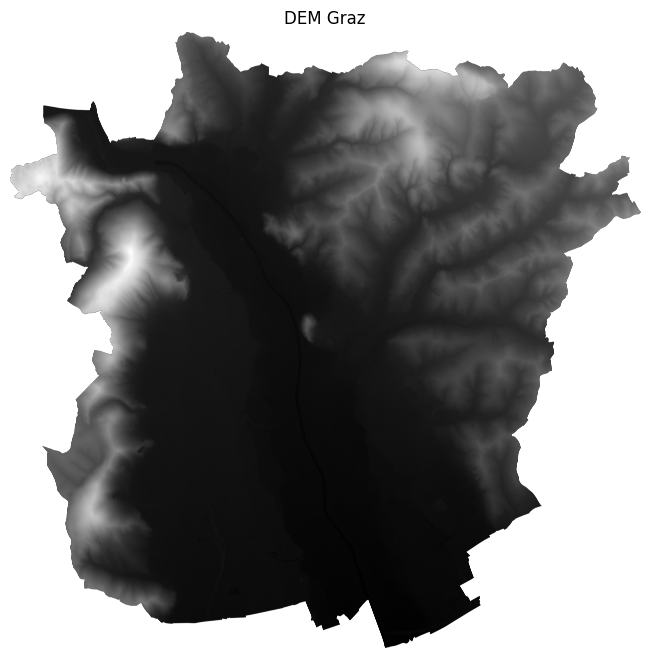

In [ ]:

nodata = clip_meta["nodata"]

# Remove band dimension and mask NoData
dem = dem_clip[0]
masked = np.ma.masked_equal(dem, nodata)

plt.figure(figsize=(10, 8))
plt.imshow(masked, cmap="gray")  

#plt.title("DEM Graz")
plt.axis("off")
plt.show()

# DEM Clip into Slope

In [ ]:


dem_path = "../data/MidtermPro/Data/RAW/dem_graz31256.tif"

slope_path = "../data/MidtermPro/Data/OutputIPYNB/DemGrazSLope31256.tif"


with rasterio.open(dem_path) as src:
    dem = src.read(1)
    transform = src.transform
    crs = src.crs
    nodata = src.nodata

    # cell size in x und y (Meter)
    xres = transform.a
    yres = -transform.e

    # compute gradients in x, y direction (Sobel like)
    # here einfache Methode: zentraldiff
    gy, gx = np.gradient(dem, yres, xres)  # yres, xres als Abstand

    # slope in radians → in degree
    slope = np.degrees(np.arctan(np.sqrt(gx*gx + gy*gy)))

    # set NoData mask
    slope = np.where(dem == nodata, nodata, slope)

    # Metadata für Output
    meta = src.meta.copy()
    meta.update({
        "dtype": "float32",
        "nodata": nodata,
        "compress": "lzw"
    })

    # Write to new GeoTIFF
    with rasterio.open(slope_path, "w", **meta) as dst:
        dst.write(slope.astype('float32'), 1)

print("Slope raster safed:", slope_path)

Slope raster gespeichert: ../data/MidtermPro/Data/OutputIPYNB/DemGrazSLope31256.tif


# Urban Atlas Clip to Graz Boundary

In [11]:

# Paths
ua_path   = Path("../data/MidtermPro/Data/RAW/UrbanAtlas31256.gpkg")
graz_path = Path("../data/MidtermPro/Data/OutputIPYNB/Graz31256.geojson")

# Load layers
urban_atlas = gpd.read_file(ua_path)
graz = gpd.read_file(graz_path)



# Fix: explicitly set correct CRS for Urban Atlas
urban_atlas = urban_atlas.set_crs("EPSG:31256", allow_override=True)

print("Urban Atlas CRS:", urban_atlas.crs)

# Clip Urban Atlas to Graz boundary
ua_graz = gpd.clip(urban_atlas, graz)

print("Original UA features:", len(urban_atlas))
print("Clipped UA features:", len(ua_graz))

# Save clipped Urban Atlas
ua_clip_path = Path("../data/MidtermPro/Data/OutputIPYNB/UrbanAtlasGraz31256.gpkg")
ua_graz.to_file(ua_clip_path, driver="GPKG")

print("Clipped Urban Atlas saved to:", ua_clip_path)


Urban Atlas CRS: EPSG:31256
Original UA features: 53713
Clipped UA features: 4344
Clipped Urban Atlas saved to: ../data/MidtermPro/Data/OutputIPYNB/UrbanAtlasGraz31256.gpkg


In [ ]:


# Load clipped Urban Atlas (EPSG:31256)
ua_path = "../data/MidtermPro/Data/UrbanAtlasGraz31256.gpkg"
ua_graz = gpd.read_file(ua_path)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

ua_graz.plot(
    ax=ax,
    color="lightgray",    # uniform gray fill
    edgecolor="dimgray",  # darker boundaries
    linewidth=0.3
)

#ax.set_title("UrbanAtlasGraz", fontsize=14)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()


# Urban Atlas Graz Rasterazition

In [ ]:


# Original Urban Atlas (ohne Veränderungen)
ua_path = Path("../data/MidtermPro/Data/OutputIPYNB/UrbanAtlasGraz31256.gpkg")

# Neuer Output mit Integer-Spalte
ua_out_path = Path("../data/MidtermPro/Data/OutputIPYNB/UrbanAtlasGraz31256_code2018.gpkg")

# Load original layer
ua = gpd.read_file(ua_path)

print("Original dtype:", ua["code_2018"].dtype)

# Create new integer field
ua["code18_int"] = ua["code_2018"].astype(int)

print("Converted dtype:", ua["code18_int"].dtype)

# Save as NEW file
ua.to_file(ua_out_path, driver="GPKG")
print("Saved NEW UrbanAtlas file with integer column →", ua_out_path)

Original dtype: object
Converted dtype: int64
Saved NEW UrbanAtlas file with integer column → ../data/MidtermPro/Data/OutputIPYNB/UrbanAtlasGraz31256_code2018.gpkg


Values for Rasterpixel

In [45]:
import geopandas as gpd
from pathlib import Path

ua_path = Path("../data/MidtermPro/Data/OutputIPYNB/UrbanAtlasGraz31256_code2018.gpkg")
ua = gpd.read_file(ua_path)

print(ua[["code_2018"]].head())        # sollten z.B. '11100', '13300', ... sein

  code_2018
0     23000
1     50000
2     31000
3     12230
4     12100


In [ ]:


# Paths
ua_path   = Path("../data/MidtermPro/Data/OutputIPYNB/UrbanAtlasGraz31256_code2018.gpkg")
graz_path = Path("../data/MidtermPro/Data/OutputIPYNB/Graz31256.geojson")
out_path  = Path("../data/MidtermPro/Data/OutputIPYNB/AUGraz31256Raster_1m.tif")

# Load data
ua   = gpd.read_file(ua_path)
graz = gpd.read_file(graz_path)

# Ensure common CRS (EPSG:31256)
ua   = ua.to_crs(31256)
graz = graz.to_crs(31256)

# Raster extent = Graz boundary
minx, miny, maxx, maxy = graz.total_bounds
pixel_size = 1  # 1 m

width  = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)
transform = from_origin(minx, maxy, pixel_size, pixel_size)

# Prepare shapes: (geometry, class value from code_2018)
shapes = []
for _, row in ua.iterrows():
    if row.geometry is None or row.geometry.is_empty:
        continue
    value = int(row["code_2018"])   # direkt aus der Originalspalte
    shapes.append((row.geometry, value))

# Rasterize
raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,        # outside UA = 0
    dtype="int32"
)

# Save raster
meta = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": 1,
    "dtype": "int32",
    "crs": "EPSG:31256",
    "transform": transform
}

with rasterio.open(out_path, "w", **meta) as dst:
    dst.write(raster, 1)

print("Urban Atlas raster saved →", out_path)

print("unique values:", sorted(list(np.unique(raster))[:10]))

Urban Atlas raster saved → ../data/MidtermPro/Data/OutputIPYNB/AUGraz31256Raster_1m.tif
unique values: [np.int32(0), np.int32(11100), np.int32(11210), np.int32(11220), np.int32(11230), np.int32(11240), np.int32(11300), np.int32(12100), np.int32(12210), np.int32(12220)]


# Population density layer Reprojection

In [34]:
# Paths
pop_path  = Path("../data/MidtermPro/Data/RAW/aut_ppp_2020_constrained.tif")   # Population density raster
graz_path = Path("../data/MidtermPro/Data/OutputIPYNB/Graz31256.geojson")      # Graz boundary (EPSG:31256)

# Load Graz boundary
graz_31256 = gpd.read_file(graz_path)

print("Graz CRS:", graz_31256.crs)

# Open population density raster
with rasterio.open(pop_path) as src:
    print("Pop raster CRS:", src.crs)

Graz CRS: EPSG:31256
Pop raster CRS: EPSG:4326


In [ ]:


# Paths
src_path = Path("../data/MidtermPro/Data/RAW/aut_ppp_2020_constrained.tif")
dst_path = Path("../data/MidtermPro/Data/OutputIPYNB/AutPop2020_31256.tif")

# Target CRS
dst_crs = "EPSG:31256"

with rasterio.open(src_path) as src:
    print("Source CRS:", src.crs)

    # Compute target transform, width and height
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )

    # Copy and update metadata
    dst_meta = src.meta.copy()
    dst_meta.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # Write reprojected raster
    with rasterio.open(dst_path, "w", **dst_meta) as dst:
        for band_idx in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, band_idx),
                destination=rasterio.band(dst, band_idx),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                # Population density = continuous variable → bilinear resampling
                resampling=Resampling.bilinear
            )

print("Reprojected population raster saved to:", dst_path)

Source CRS: EPSG:4326
Reprojected population raster saved to: ../data/MidtermPro/Data/OutputIPYNB/AutPop2020_31256.tif


# Population density layer to Graz Boundary

In [ ]:


# Paths
pop_path  = Path("../data/MidtermPro/Data/OutputIPYNB/AutPop2020_31256.tif")
graz_path = Path("../data/MidtermPro/Data/OutputIPYNB/Graz31256.geojson")
clip_path = Path("../data/MidtermPro/Data/OutputIPYNB/AutPop2020_Graz31256temp.tif")

# Load Graz boundary
graz = gpd.read_file(graz_path)

with rasterio.open(pop_path) as src:
    # Reproject boundary to raster CRS if needed
    graz_raster = graz.to_crs(src.crs)

    # Extract geometry
    geom = [json.loads(graz_raster.to_json())["features"][0]["geometry"]]

    # Clip (NoData kept as src.nodata)
    clipped, transform = mask(
        src,
        geom,
        crop=True,
        nodata=src.nodata
    )

    meta = src.meta.copy()
    meta.update({
        "height": clipped.shape[1],
        "width": clipped.shape[2],
        "transform": transform,
        "nodata": src.nodata
    })

# Save temporary clipped raster
with rasterio.open(clip_path, "w", **meta) as dst:
    dst.write(clipped)

print("Clipped raster saved:", clip_path)

Clipped raster saved: ../data/MidtermPro/Data/OutputIPYNB/AutPop2020_Graz31256temp.tif


In [ ]:


src_path = Path("../data/MidtermPro/Data/OutputIPYNB/AutPop2020_Graz31256temp.tif")
dst_path = Path("../data/MidtermPro/Data/OutputIPYNB/PopDensGraz31256_final.tif")

with rasterio.open(src_path) as src:
    arr = src.read(1)

    nodata = src.nodata
    print("nodata:", nodata)

    # Replace nodata with 0
    arr = np.where(arr == nodata, 0, arr)
    arr = np.where(np.isnan(arr), 0, arr)

    # Update metadata: remove nodata flag
    meta = src.meta.copy()
    meta.pop("nodata", None)

    with rasterio.open(dst_path, "w", **meta) as dst:
        dst.write(arr, 1)

print("Filled raster saved:", dst_path)

# Check values
print("min:", arr.min(), "max:", arr.max())

nodata: -99999.0
Filled raster saved: ../data/MidtermPro/Data/OutputIPYNB/PopDensGraz31256_final.tif
min: 0.0 max: 36.58268


In [40]:
with rasterio.open("../data/MidtermPro/Data/OutputIPYNB/PopDensGraz31256_final.tif") as src:
    arr = src.read(1)
    print(arr.max())

36.58268


# Timon Schritte

In [ ]:
# define the place name
place_name:str = "Graz, Austria"
# get the boundary polygon of Graz
graz_gdf = ox.geocode_to_gdf(place_name)
graz_gdf.to_file("graz_boundary.geojson", driver="GeoJSON")
# change the crs to an Austrian metric CRS EPSG: 31256
graz_gdf = graz_gdf.to_crs(epsg=31256)






'\nThe author\'s of the paper obtained the road and drainage network from the Ministry of Agriculture\nand the Addis Ababa city land administration. We use the logical equivalent from OSM.\nPaper speaks of "drainage" also in respect to recreation. For that, we will choose rivers and streams.\ntags: waterway=river, waterway=stream, waterway=canal for drainage network\n\nFor the road network, accessibility and pollution is relevant, so will choose the drivable road network.\nnetwork_type=\'drive\' for drivable road network (excluding footways, cycleways, etc.)\n\n\n\n'

In [ ]:
"""
The author's of the paper obtained the road and drainage network from the Ministry of Agriculture
and the Addis Ababa city land administration. We use the logical equivalent from OSM.
Paper speaks of "drainage" also in respect to recreation. For that, we will choose rivers and streams.
tags: waterway=river, waterway=stream, waterway=canal for drainage network

For the road network, accessibility and pollution is relevant, so will choose the drivable road network.
network_type='drive' for drivable road network (excluding footways, cycleways, etc.)
"""

# get the road network within Graz
road_graph = ox.graph_from_place(place_name, network_type='drive')
road_gdf = ox.graph_to_gdfs(road_graph, nodes=False, edges=True)
road_gdf = road_gdf.to_crs(epsg=31256)
road_gdf.to_file("graz_road_network.geojson", driver="GeoJSON")

# get the drainage network within Graz
#https://wiki.openstreetmap.org/wiki/Key:waterway
drainage_tags = {'waterway': ['river', 'stream', 'canal']}
drainage_gdf = ox.features_from_place(place_name, tags=drainage_tags)
drainage_gdf = drainage_gdf.to_crs(epsg=31256)
drainage_gdf.to_file("graz_drainage_network.geojson", driver="GeoJSON")

# we only want lines, no polygons or points
drainage_gdf = drainage_gdf[drainage_gdf.geometry.type.isin(['LineString', 'MultiLineString'])]
drainage_gdf = drainage_gdf[['geometry', 'waterway', 'name']] # keep names
drainage_gdf.to_file("graz_drainage_network.geojson", driver="GeoJSON")

# print summary
print(f"Graz boundary: {graz_gdf.shape[0]} features")
print(f"Graz road network: {road_gdf.shape[0]} features")
print(f"Graz drainage network: {drainage_gdf.shape[0]} features")

Graz boundary: 1 features
Graz road network: 11255 features
Graz drainage network: 997 features


In [ ]:
"""
Make raster base layer for Graz with 10m resolution
"""
# define raster parameters
raster_res = 10  # 10 meters
minx, miny, maxx, maxy = graz_gdf.total_bounds

  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl.metadata (6.5 kB)
   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   ----- ---------------------------------- 3.4/25.4 MB 16.7 MB/s eta 0:00:02
   --------- ------------------------------ 6.0/25.4 MB 14.2 MB/s eta 0:00:02
   -------------- ------------------------- 9.2/25.4 MB 15.0 MB/s eta 0:00:02
   ------------------- -------------------- 12.3/25.4 MB 14.8 MB/s eta 0:00:01
   ------------------------ --------------- 15.5/25.4 MB 14.7 MB/s eta 0:00:01
   ------------------------------ --------- 19.4/25.4 MB 15.1 MB/s eta 0:00:01
   ----------------------------------- ---- 22.8/25.4 MB 15.5 MB/s eta 0:00:01
   ---------------------------------------  25.4/25.4 MB 15.6 MB/s eta 0:00:01
   ---------------------------------------- 25.4/25.4 MB 14.9 MB/s eta 0:00:00
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
   ------------------------------


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#test for git 2